In [25]:
import pathlib as plib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



root = "/scratch"


In [2]:
# 24x32
model_dir = "../celeba_adafruit_outdim768_height0.27_scene2mask0.55_poisson40.0_downpsf8.0_NORM_100000files_50epoch_seed0_SingleHidden800_06092022_13h54"


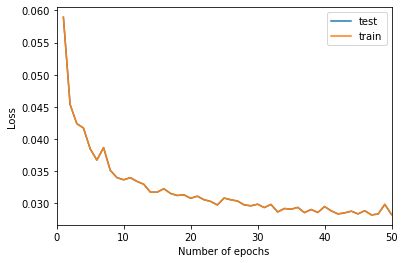

In [3]:
model_dir = plib.Path(model_dir)

train_loss = np.load(str(model_dir /"train_loss.npy"))
test_loss = np.load(str(model_dir / "test_loss.npy"))

n_epoch = np.arange(len(test_loss)) + 1
plt.plot(n_epoch,  test_loss, label="test")
plt.plot(n_epoch,  test_loss, label="train")
plt.legend()
# plt.ylim([0.86, 0.91])
plt.ylabel("Loss")
plt.xlabel("Number of epochs")
plt.xlim([0, 50]);


In [5]:
import numpy as np
import pathlib as plib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from lenslessclass.generator import SingleHidden
from lenslessclass.datasets import CelebAAugmented
import json
from pprint import pprint
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from waveprop.devices import slm_dict, sensor_dict
import torchvision.datasets as dset
import matplotlib


# Opening JSON file
f = open(str(model_dir / "metadata.json"))
metadata = json.load(f)
pprint(metadata)

{'batch_size': 100,
 'best_test_loss': 0.028223161697387686,
 'best_test_loss_epoch': 47,
 'dataset': '/home/bezzam/LenslessClassification/data_celeba/celeba_adafruit_outdim768_height0.27_scene2mask0.55_poisson40.0_downpsf8.0_NORM_100000files',
 'hidden_dim': 800,
 'mean': 0.48658260703086853,
 'model': 'SingleHidden800',
 'noise_type': 'poisson',
 'seed': 0,
 'snr': 40.0,
 'std': 0.25949734449386597,
 'timestamp (DDMMYYYY_HhM)': '06092022_13h54'}


In [27]:
# TODO save train-test indices in metadata!!
attr = "Male"
test_size = 0.15
seed = 0

In [28]:
# full dataset
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(metadata["mean"], metadata["std"])])
all_data = CelebAAugmented(path=metadata["dataset"], transform=trans, return_original="/scratch")

# get train-test split
ds = dset.CelebA(
    root=root,
    split="all",
    download=False,
)
n_files = len(all_data)
if n_files is None:
    n_files = len(ds)
    train_size = 1 - test_size
else:
    print(f"Using {n_files}")
    test_size = int(n_files * test_size)
    train_size = n_files - test_size
label_idx = ds.attr_names.index(attr)
labels = ds.attr[:, label_idx][:n_files]
train_indices, test_indices, _, _ = train_test_split(
    range(n_files),
    labels,
    train_size=train_size,
    test_size=test_size,
    stratify=labels,
    random_state=seed,
)


Using 100000


NameError: name 'Subset' is not defined

In [29]:
from torch.utils.data import Subset

# load test set
test_set = Subset(all_data, test_indices)
print(len(test_set))


15000


In [30]:
test_set[0][0].shape

torch.Size([1, 24, 32])

In [31]:
test_set[0][2].shape

torch.Size([1, 218, 178])

In [32]:
from lenslessclass.util import device_checks

# load model
use_cuda = torch.cuda.is_available()
if use_cuda:
    print("CUDA available, using GPU.")
    device = "cuda:1"
else:
    device = "cpu"
    print("CUDA not available, using CPU.")

device, use_cuda, multi_gpu, device_ids = device_checks(device=device, single_gpu=False)


model = SingleHidden(
    input_shape=np.prod(test_set[0][0].shape), 
    hidden_dim=metadata["hidden_dim"], 
    n_output=np.prod(test_set[0][2].shape), 
)
if use_cuda:
    model = model.to(device)
model = nn.DataParallel(model, device_ids=device_ids)

# -- load from state dict
state_dict_fp = str(model_dir / "state_dict.pth")
model.load_state_dict(torch.load(state_dict_fp))


CUDA available, using GPU.
-- using 2 GPUs


<All keys matched successfully>

In [33]:
print("\nModel's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
module.linear1.weight 	 torch.Size([800, 768])
module.linear1.bias 	 torch.Size([800])
module.linear2.weight 	 torch.Size([38804, 800])
module.linear2.bias 	 torch.Size([38804])


In [34]:
target_dim = np.array([218, 178])

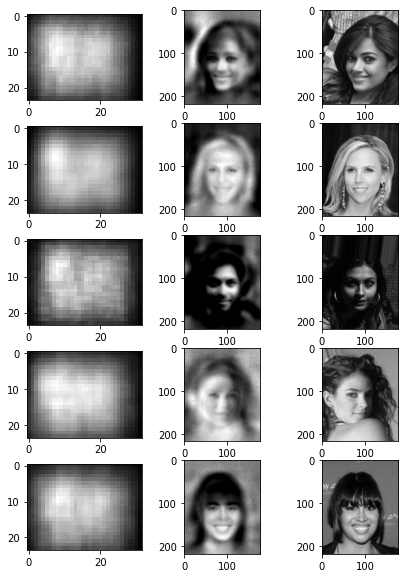

In [45]:
# IDX = [0, 1, 2, 11, 121, 77]
IDX = np.arange(10, 15)
# bad (3x4) : 11, 121, 77

plt.figure(figsize=(7,10))
for n, _idx in enumerate(IDX):
    # generate
    ex = test_set[_idx]
    gen_out = model(ex[0])
    gen_out_img = gen_out.detach().cpu().numpy().squeeze().reshape(target_dim[0], target_dim[1])

    # plot
    plot_ind = n * 3 + 1
    plt.subplot(len(IDX), 3, plot_ind)
    plt.imshow(ex[0].detach().cpu().numpy().squeeze(), cmap="gray")
    plt.subplot(len(IDX), 3, plot_ind + 1)
    plt.imshow(gen_out_img, cmap="gray")
    plt.subplot(len(IDX), 3, plot_ind + 2)
    plt.imshow(ex[2].cpu().numpy().squeeze(), cmap="gray")

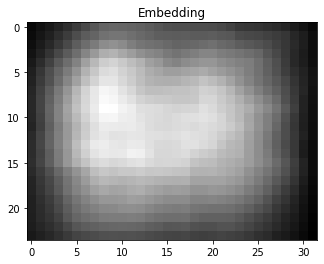

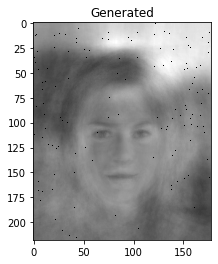

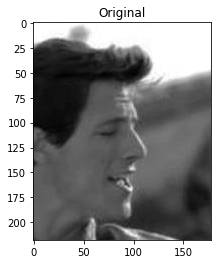

In [14]:
IDX = 2
# IDX = 11
# IDX = 121
# IDX = 77

# generate
ex = test_set[IDX]
gen_out = model(ex[0])
gen_out_img = gen_out.detach().cpu().numpy().squeeze().reshape(target_dim[0], target_dim[1])

# plot
plt.imshow(ex[0].detach().cpu().numpy().squeeze(), cmap="gray")
plt.title("Embedding")
plt.show()
plt.imshow(gen_out_img, cmap="gray")
plt.title("Generated")
plt.show()
plt.imshow(ex[2].cpu().numpy().squeeze(), cmap="gray")
plt.title("Original")
plt.show()

In [13]:
ex[2].max()

tensor(1.)

# sweep over number of training examples